# HLCV Project

In [ ]:
Name = "Luisa Danalachi"
Matriculation_Number = "7022909"

Name = "Victor Martinez Palomares"
Matriculation_Number = "7021729"

Name = "Soham Roy"
Matriculation_Number = "7028704"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir ./datasets
# !mkdir ./datasets/lyme_dataset
# !cp -r drive/MyDrive/Colab\ Notebooks/HLCV_project/datasets/lyme_dataset.zip ./datasets
# !unzip -q -o "./datasets/lyme_dataset.zip" -d "./datasets/lyme_dataset"

# '''
# !mkdir ./resources

# !cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources
# !cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources

# '''

# Imports

In [1]:
import os
import glob
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.utils.data as data

### Params

In [3]:
IMAGE_SIZE = 256
EPOCHS = 120
BATCH = 4
LR = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)


Using device: cuda


# Define data augmentations

In [4]:
data_aug_transforms = []

data_aug_transforms.append(transforms.RandomRotation([-90, 90]) ) 
data_aug_transforms.append( transforms.RandomHorizontalFlip() )
data_aug_transforms.append(transforms.ColorJitter(brightness = 0.2)) 

norm_transforms = [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                   transforms.ToTensor(), 
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

train_transforms = transforms.Compose(data_aug_transforms + norm_transforms)

# Add Compose
test_transforms =transforms.Compose(norm_transforms) 

# Load Lyme DS

In [5]:
#Load Lyme
lyme_train_data_path = "./datasets/Lyme/Train/Train_2_Cases"
lyme_test_data_path = "./datasets/Lyme/Validation/Validation_2_Cases"

# ImageFolder is a generic data loader where the images are arranged in multiple folders

#Load TRAIN
lyme_train_data = torchvision.datasets.ImageFolder(root=lyme_train_data_path, transform=train_transforms)
lyme_train_data_loader = data.DataLoader(lyme_train_data, batch_size=BATCH, shuffle=True)
print("Lyme Dermnet data:", lyme_train_data)

# Load TEST 
lyme_test_data = torchvision.datasets.ImageFolder(root=lyme_test_data_path, transform=test_transforms)
lyme_test_data_loader = data.DataLoader(lyme_test_data, batch_size=BATCH)

# Check list of classes
# Are converted to 0,1 etc when call enumerate()
list_of_classes=list(map(str, list(lyme_train_data.classes)) )
print("Lyme classes:", list_of_classes)

Lyme Dermnet data: Dataset ImageFolder
    Number of datapoints: 357
    Root location: ./datasets/Lyme/Train/Train_2_Cases
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=None, hue=None)
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Lyme classes: ['Lyme_Negative', 'Lyme_Positive']


# Train val split

In [6]:
val_split = 0.1

num_training = int((1 - val_split) * len(lyme_train_data))
num_validation = len(lyme_train_data) - num_training
mask = list(range(num_training))

train_dataset = torch.utils.data.Subset(lyme_train_data, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(lyme_train_data, mask)

# Create DataLoaders
lyme_train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, drop_last=True)
lyme_validation_data_loader = data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True, drop_last=True)


print(len(train_dataset))
print(len(val_dataset))
print(len(lyme_test_data))

print(len(lyme_train_data_loader))
print(len(lyme_validation_data_loader))
print(len(lyme_test_data_loader)) #did not add drop_last=True to TEST

321
36
87
80
9
22


## Check dataloader 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


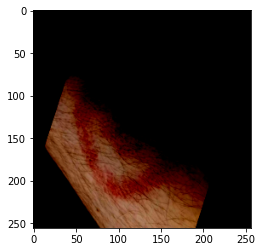

CLass:  tensor(1)


In [7]:
iterator=iter(lyme_validation_data_loader)
inputs, classes = next(iterator)
print(len(inputs)) 

plt.imshow(inputs[2].squeeze().permute(2,1,0))
plt.show()
print("CLass: ",classes[2])

# Load Dermnet DS

In [8]:
#Load Dermnet
dermnet_train_data_path = "./datasets/Dermnet/train"
dermnet_test_data_path = "./datasets/Dermnet/test"

# ImageFolder is a generic data loader where the images are arranged in multiple folders
dermnet_train_data = torchvision.datasets.ImageFolder(root=dermnet_train_data_path, transform=train_transforms)
dermnet_train_data_loader = data.DataLoader(dermnet_train_data, batch_size=BATCH, shuffle=True)
print("Details Dermnet data:", dermnet_train_data)

# Load test 
dermnet_test_data = torchvision.datasets.ImageFolder(root=dermnet_test_data_path, transform=test_transforms)
dermnet_test_data_loader = data.DataLoader(dermnet_train_data, batch_size=BATCH)

# Load list of classes
list_of_classes=list(map(str, list(dermnet_train_data.classes)) )
print("Dermnet classes", list_of_classes)

Details Dermnet data: Dataset ImageFolder
    Number of datapoints: 15557
    Root location: ./datasets/Dermnet/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=None, hue=None)
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dermnet classes ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation'

### Create Model

In [9]:
from torchvision import models
#from torchvision.models import ResNet50_Weights

layer_config= [2048, 512, 256]
num_classes = 1
num_epochs = 30
batch_size = 200
learning_rate = 1e-5
learning_rate_decay = 0.99

# Create ResNet 50 model pretrained with ImageNet
class ResNet50(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(ResNet50, self).__init__()
        self.net = models.resnet50(pretrained=pretrained)
        
        # add new classifier layers
        self.net.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(layer_config[0], layer_config[1]),
            nn.BatchNorm1d(layer_config[1]),
            nn.ReLU(),
            nn.Linear(layer_config[1], layer_config[2]),
            nn.BatchNorm1d(layer_config[2]),
            nn.ReLU(),
            nn.Linear(layer_config[2], n_class)
        )       

    def forward(self, x):
        out = self.net(x)
        return out.view(-1, 1).squeeze(1).type(torch.FloatTensor) 

# Initialize the model for this run
fine_tune = True
pretrained = True
model= ResNet50(num_classes, fine_tune, pretrained)
print(model)


print("Params to learn:")
if fine_tune:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


model.to(device)

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

# Finetuning

In [15]:
CUDA_LAUNCH_BLOCKING="1"


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# store best model and acc
best_model_name = 'bestmodel_resnet50_imagenet.ckpt'
best_model = None
best_val_acc = 0.


loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(lyme_train_data_loader)

for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(lyme_train_data_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
        loss = criterion(outputs, labels.float()) # labels are stored as float need cast to int

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())
    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in lyme_validation_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).to(device)
            predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
            
            loss = criterion(outputs, labels.float())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model
            print("New best validation accuracy: {} %".format(best_val_acc))


        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        val_acc_history.append(val_accuracy)
        val_loss_history.append(loss.item())
  
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

Epoch [1/30], Step [10/80], Loss: 0.9022
Epoch [1/30], Step [20/80], Loss: 0.7290
Epoch [1/30], Step [30/80], Loss: 0.6306
Epoch [1/30], Step [40/80], Loss: 0.6624
Epoch [1/30], Step [50/80], Loss: 0.6195
Epoch [1/30], Step [60/80], Loss: 0.5262
Epoch [1/30], Step [70/80], Loss: 0.6554
Epoch [1/30], Step [80/80], Loss: 0.5904
Train accuracy is: 61.25 %


C:\Users\luisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


New best validation accuracy: 52.77777777777778 %
Validataion accuracy is: 52.77777777777778 %
Epoch [2/30], Step [10/80], Loss: 0.7072
Epoch [2/30], Step [20/80], Loss: 0.6132
Epoch [2/30], Step [30/80], Loss: 0.6954
Epoch [2/30], Step [40/80], Loss: 0.6038
Epoch [2/30], Step [50/80], Loss: 0.7589
Epoch [2/30], Step [60/80], Loss: 0.7372
Epoch [2/30], Step [70/80], Loss: 0.4736
Epoch [2/30], Step [80/80], Loss: 0.4997
Train accuracy is: 68.125 %
Validataion accuracy is: 50.0 %
Epoch [3/30], Step [10/80], Loss: 0.6842
Epoch [3/30], Step [20/80], Loss: 0.4575
Epoch [3/30], Step [30/80], Loss: 0.4991
Epoch [3/30], Step [40/80], Loss: 0.6572
Epoch [3/30], Step [50/80], Loss: 0.4382
Epoch [3/30], Step [60/80], Loss: 0.7709
Epoch [3/30], Step [70/80], Loss: 0.6667
Epoch [3/30], Step [80/80], Loss: 0.5107
Train accuracy is: 71.25 %
Validataion accuracy is: 47.22222222222222 %
Epoch [4/30], Step [10/80], Loss: 0.4601
Epoch [4/30], Step [20/80], Loss: 0.7833
Epoch [4/30], Step [30/80], Loss: 0

KeyboardInterrupt: 